In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import RandomSampler
from optuna.pruners import NopPruner
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, recall_score
from tqdm import tqdm

import sys
sys.path.append("../scripts")

import data
import experiments
import utils


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairGBMClassifier_eod" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "M2FGB_grad" : "#8da0cb",
    "M2FGB_grad_tpr" : "#8da0cb",
    "M2FGB_grad_pr" : "#8da0cb",
    "MinimaxPareto" : "pink"
}

In [19]:
dataset = "adult"
fold = 0
n_jobs = 6
seed = 42
X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test =  data.get_fold(dataset, fold, 10, 4, seed)

{'Male_False': 0, 'Male_True': 1, 'Female_False': 2, 'Female_True': 3}


In [4]:
def plot_perf_lines(df_models, fair_metric = "min_acc"):
    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 5))
    for model in df_models["model"].unique():
        df_model = df_models[df_models["model"] == model]
        
        for i, metric in enumerate(["recall", "bal_acc", fair_metric, "score"]):
            axs[i].plot(df_model["alpha"], df_model[metric], label = model, color = methods_color[model], lw = 2)
            axs[i].set_title(metric)
            axs[i].set_xlabel("alpha")
            axs[i].legend()
    plt.show()

## 100 random models, similar to prev experiments

In [5]:
def eval_model_list(model_list, X, Y, A, threshold_list = None):
    results = []
    for m, model in enumerate(model_list):
        y_score = model.predict_proba(X)[:, 1]
        if threshold_list is None:
            thresh = 0.5
        else:
            thresh = threshold_list[m]
            
        y_pred = y_score > thresh
        roc = roc_auc_score(Y, y_score)
        bal_acc = balanced_accuracy_score(Y, y_pred)
        acc = accuracy_score(Y, y_pred)
        rec = recall_score(Y, y_pred)
        min_tpr = 1 - utils.min_true_positive_rate(Y, y_pred, A)
        min_pr = 1 - utils.min_positive_rate(Y, y_pred, A)
        min_bal_acc = 1 - utils.min_balanced_accuracy(Y, y_pred, A)
        min_acc = 1 - utils.min_accuracy(Y, y_pred, A)

        results.append({
            "model" : m,
            "roc" : roc,
            "bal_acc" : bal_acc,
            "acc" : acc,
            "rec" : rec,
            "min_tpr" : min_tpr,
            "min_pr" : min_pr,
            "min_bal_acc" : min_bal_acc,
            "min_acc" : min_acc
        })

    return pd.DataFrame(results)

In [6]:
def exp_v1(model, n_trials = 100):
    model_list = []
    param_space = experiments.get_param_spaces(model)
    param_list = experiments.get_param_list(param_space, n_trials)
    model_class = experiments.get_model(model, random_state=seed)
    threshold_list = []
    for params in tqdm(param_list):
        model_ = model_class(**params)
        model_.fit(X_train, Y_train, A_train)
        model_list.append(model_)
        # get the best threshold for each model
        y_score = model_.predict_proba(X_train)[:, 1]
        threshold_list.append(utils.get_best_threshold(Y_train, y_score))
    
    results_train = eval_model_list(
        model_list,
        X_train,
        Y_train,
        A_train,
        threshold_list
    )

    results_val = eval_model_list(
        model_list,
        X_val,
        Y_val,
        A_val,
        threshold_list
    )

    results_test = eval_model_list(
        model_list,
        X_test,
        Y_test,
        A_test,
        threshold_list
    )

    return {
        "model_list" : model_list,
        "results_train" : results_train,
        "results_val" : results_val,
        "results_test" : results_test
    }



def select_model_alpha(model, results_val, results_test, fair_metric):
    alpha_list = [i/10 for i in range(11)]
    results = []

    assert fair_metric in ["min_acc", "min_bal_acc", "min_tpr"]

    for alpha in alpha_list:
        # get best model in validation
        score = results_val["bal_acc"] * alpha + results_val[fair_metric] * (1 - alpha)
        best_model = results_val.iloc[score.idxmax()].model.astype(int)

    
        # get score in test
        r = results_test.iloc[best_model]
        score = r["bal_acc"] * alpha + r[fair_metric] * (1 - alpha)

        results.append({
            "model" : model,
            "alpha" : alpha,
            "bal_acc" : r["bal_acc"],
            "recall" : r["rec"],
            fair_metric : r[fair_metric],
            "score" : score
        })

    return pd.DataFrame(results)


def select_model_alpha_fairgbm(model, results_val, results_test, fair_metric, n_trials = 1000
):
    alpha_list = [i/10 for i in range(11)]
    results = []
    for alpha in alpha_list:
        for trial_i in range(n_trials):
            # random sample some models
            r = results_val.sample(20)
            # get best model in validation
            score = r["bal_acc"] * alpha + r[fair_metric] * (1 - alpha)
            best_model = r.loc[score.idxmax(), :].model.astype(int)
            # get score in test
            r = results_test.iloc[best_model]
            score = r["bal_acc"] * alpha + r[fair_metric] * (1 - alpha)

            results.append({
                "model" : model,
                "alpha" : alpha,
                "trial_i" : trial_i,
                "recall" : r["rec"],
                "bal_acc" : r["bal_acc"],
                fair_metric : r[fair_metric],
                "score" : score
            })

    results = pd.DataFrame(results)
    results = results.groupby(["model", "alpha"]).mean().reset_index()
    return results


In [20]:
results = {}
for model in ["LGBMClassifier", "M2FGB_grad"]:#, "M2FGB_grad_tpr"]:
    results[model] = exp_v1(model, 100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


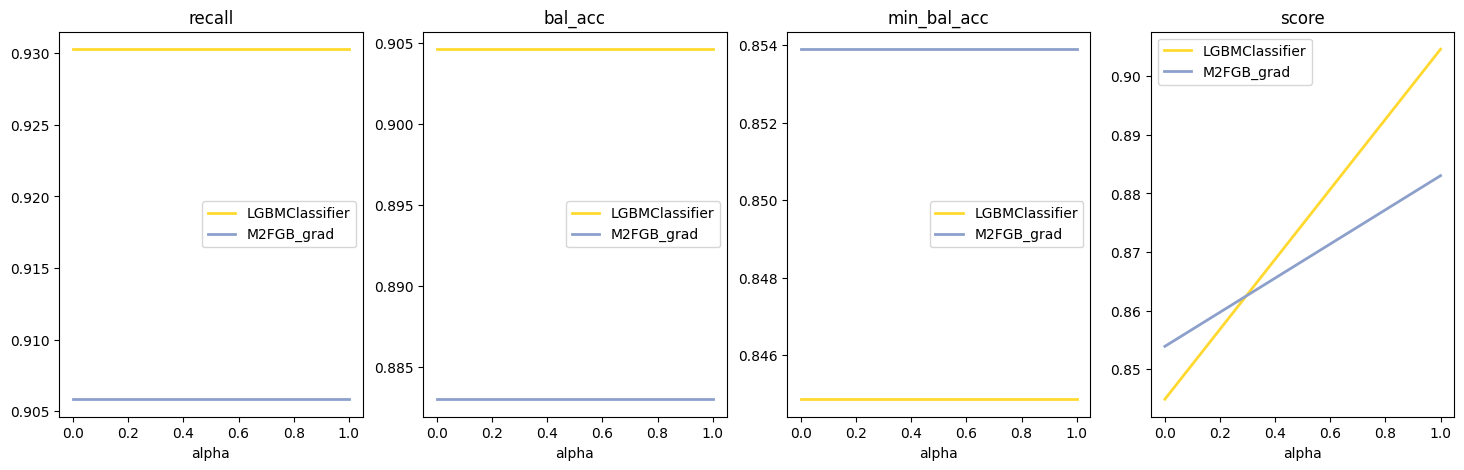

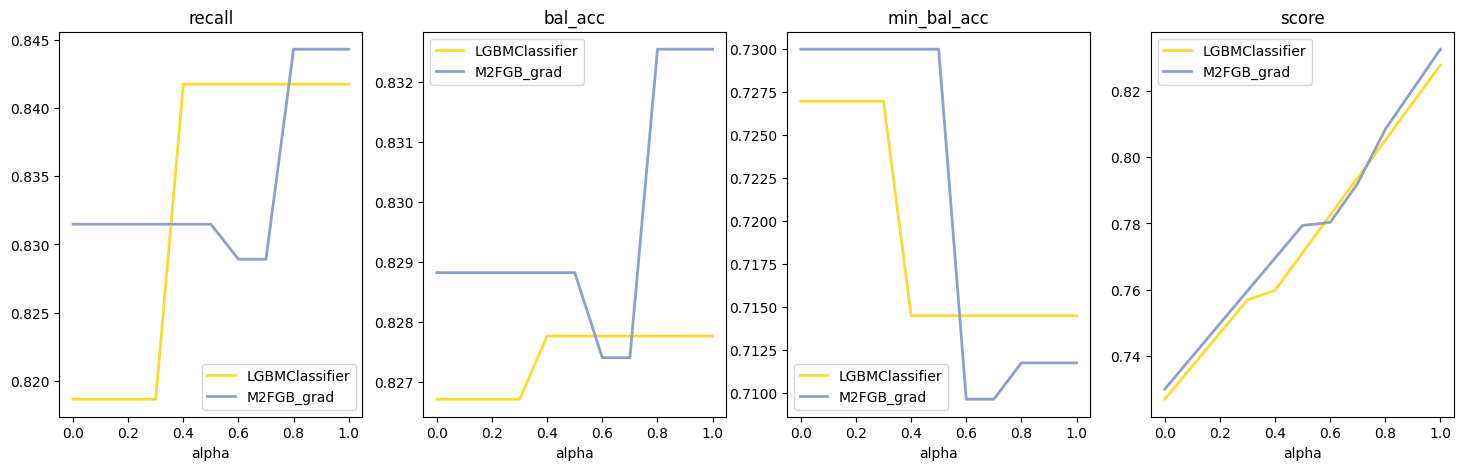

In [21]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

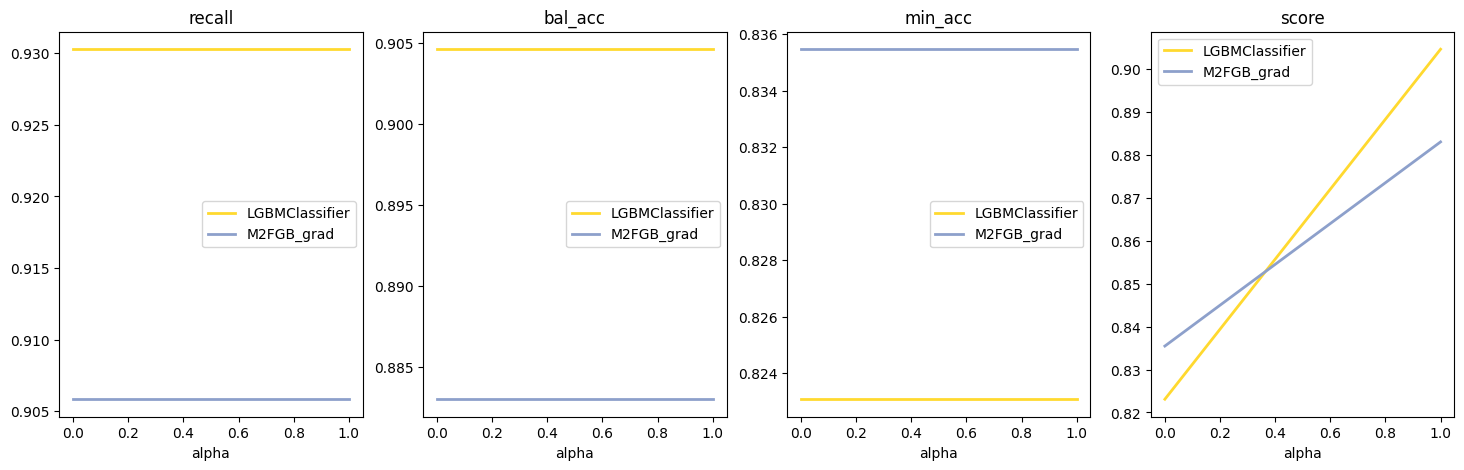

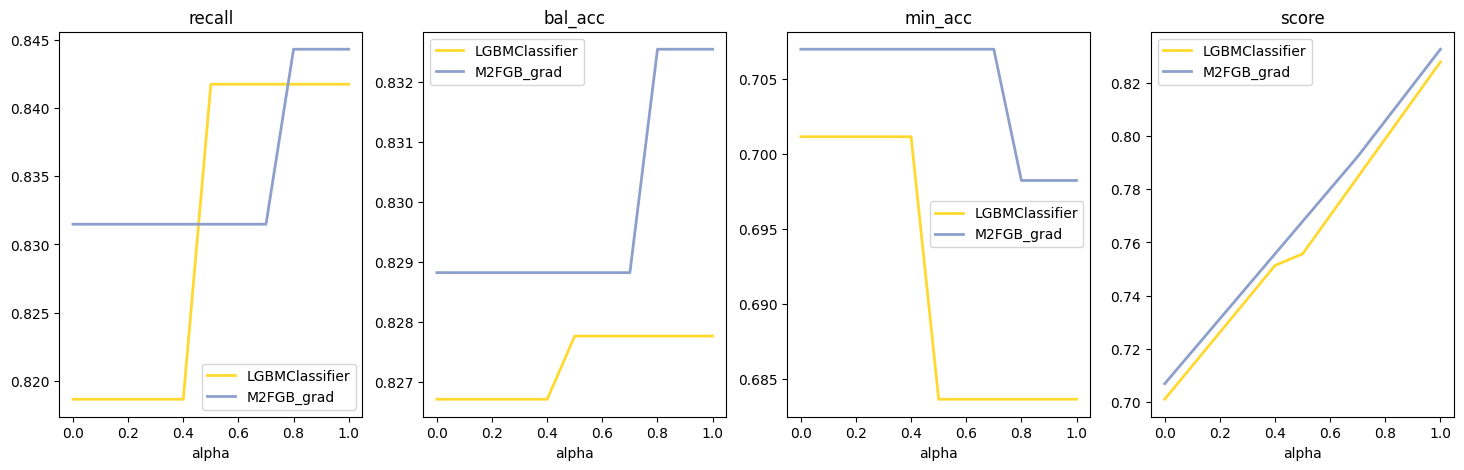

In [23]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

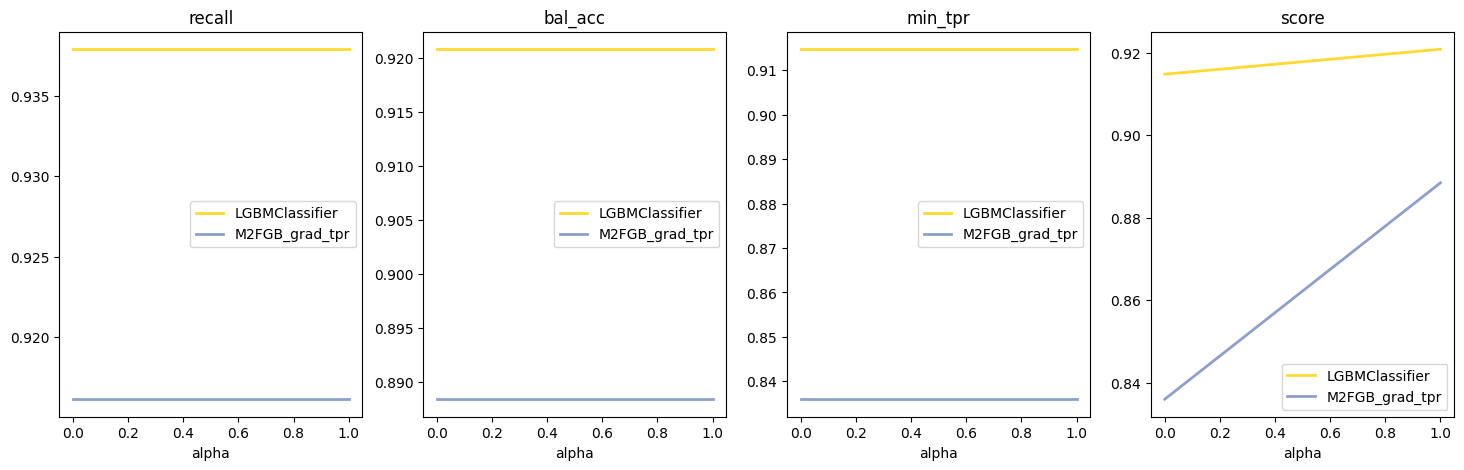

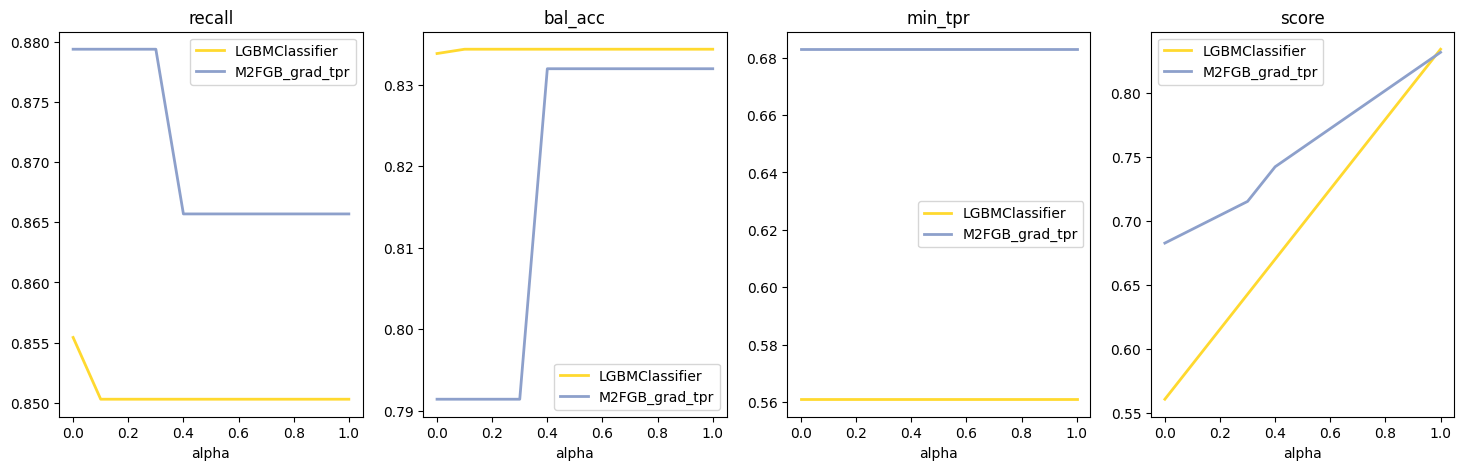

In [159]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

### fairgbm procedure

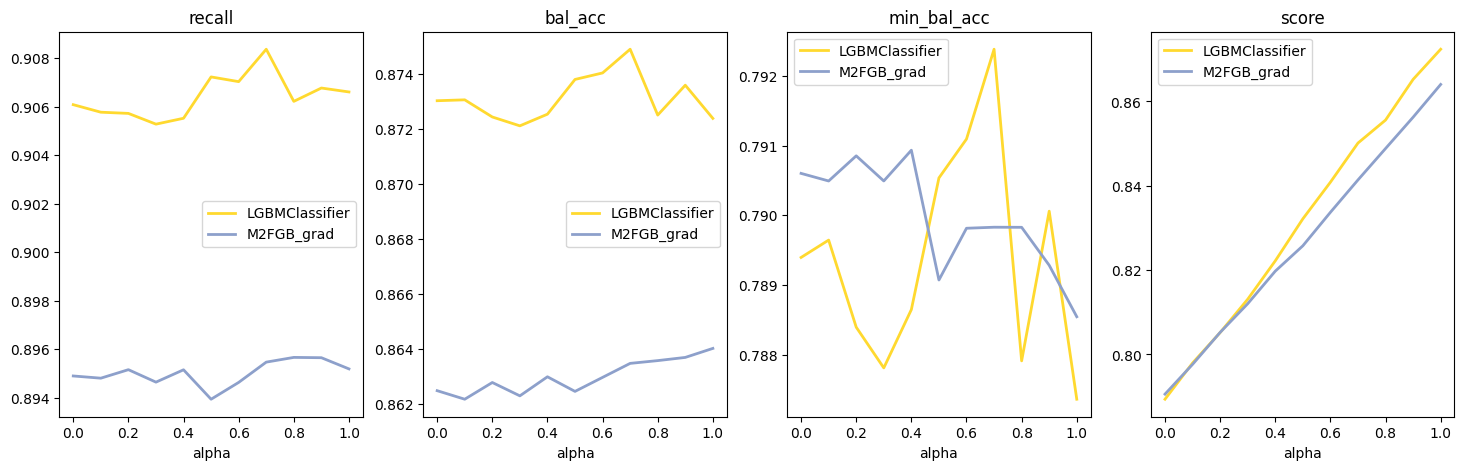

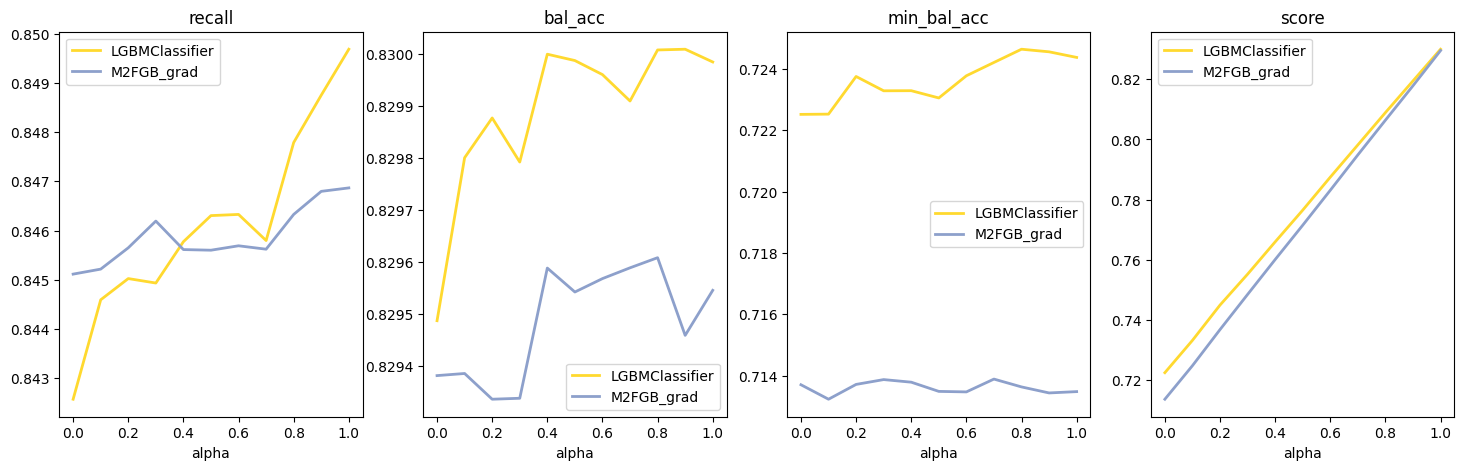

In [236]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

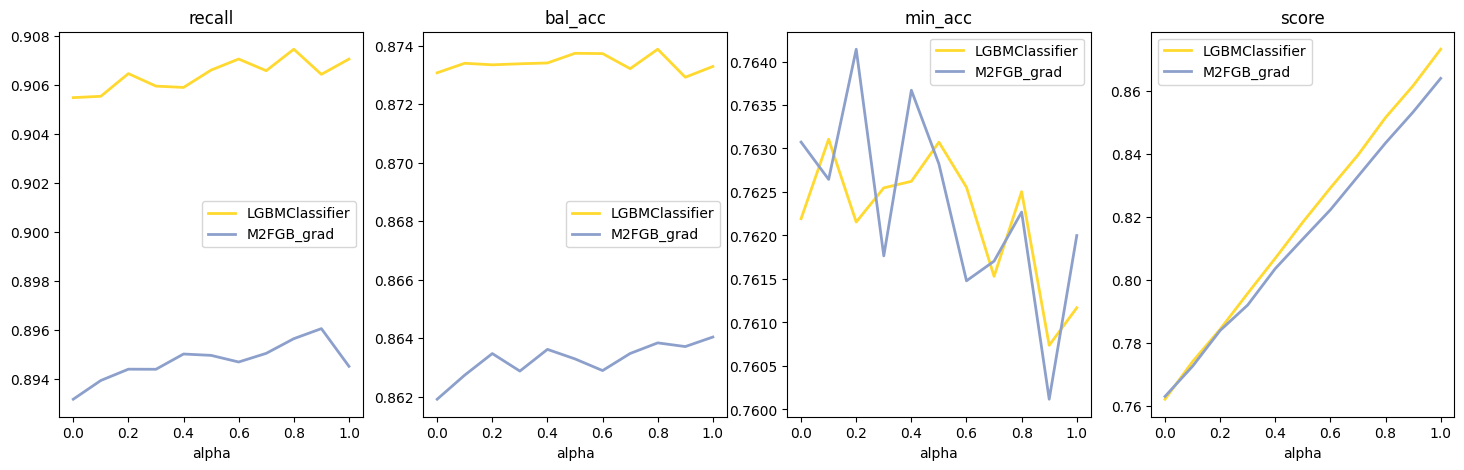

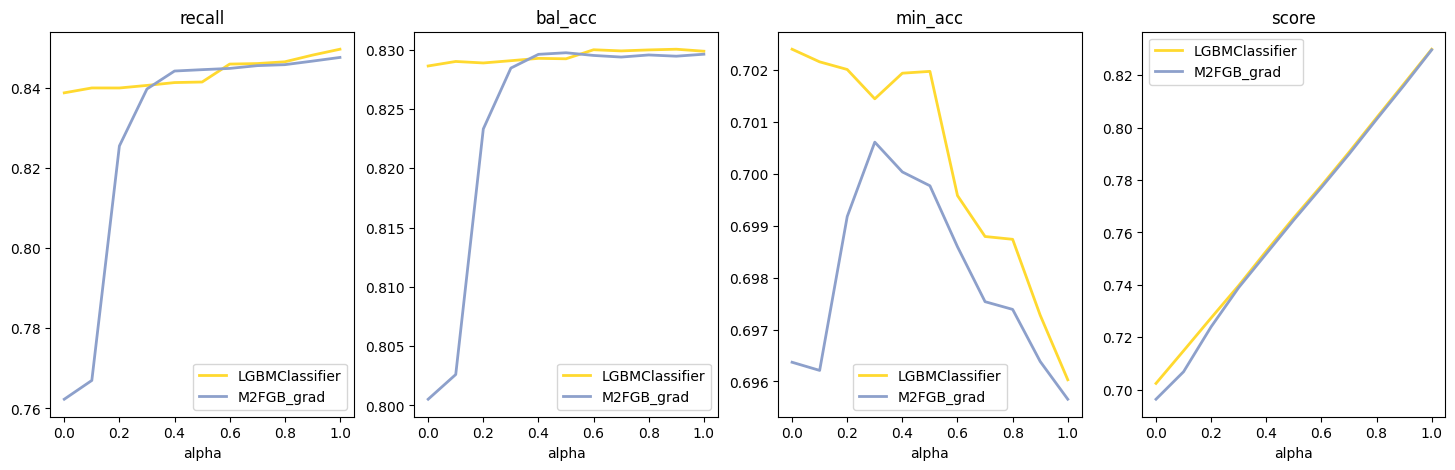

In [237]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

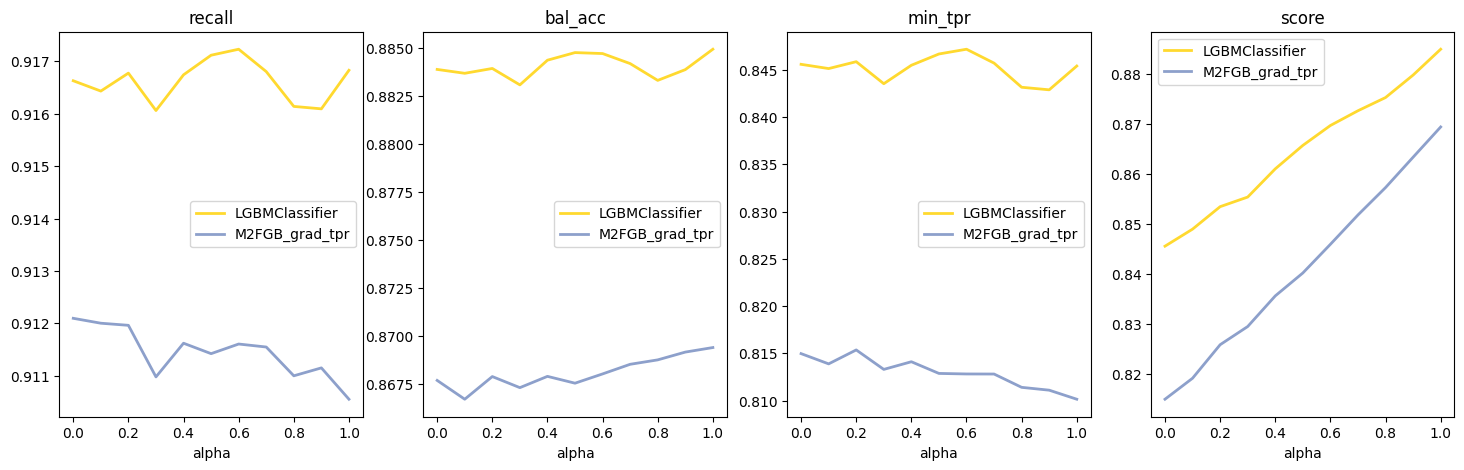

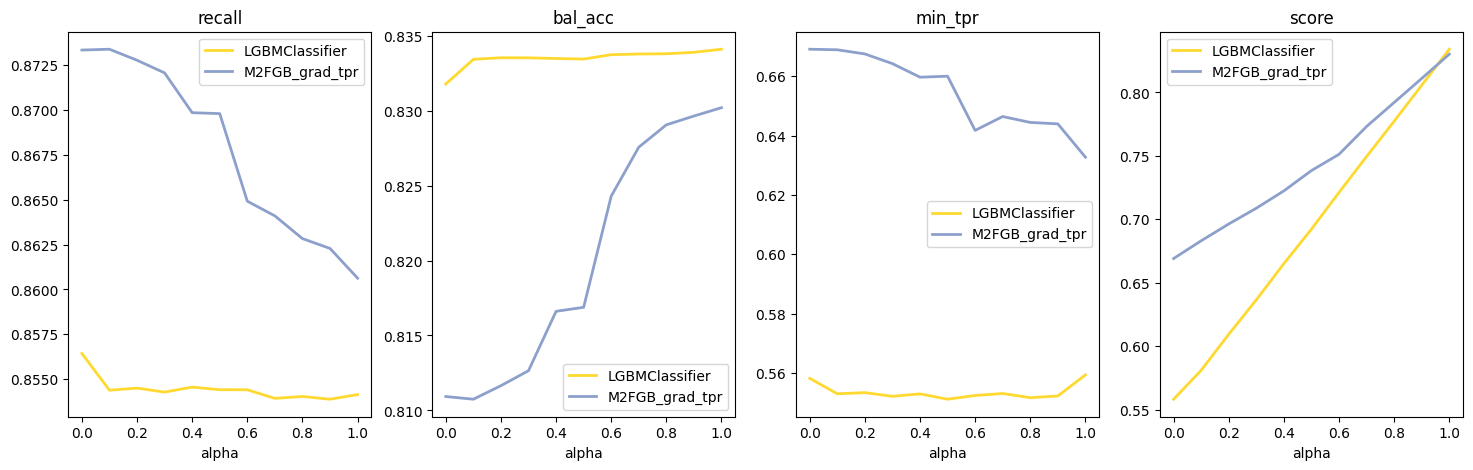

In [163]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

## with really more trials

In [165]:
results = {}
for model in ["LGBMClassifier", "M2FGB_grad", "M2FGB_grad_tpr"]:
    results[model] = exp_v1(model, 750)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [11:41<00:00,  1.07it/s]


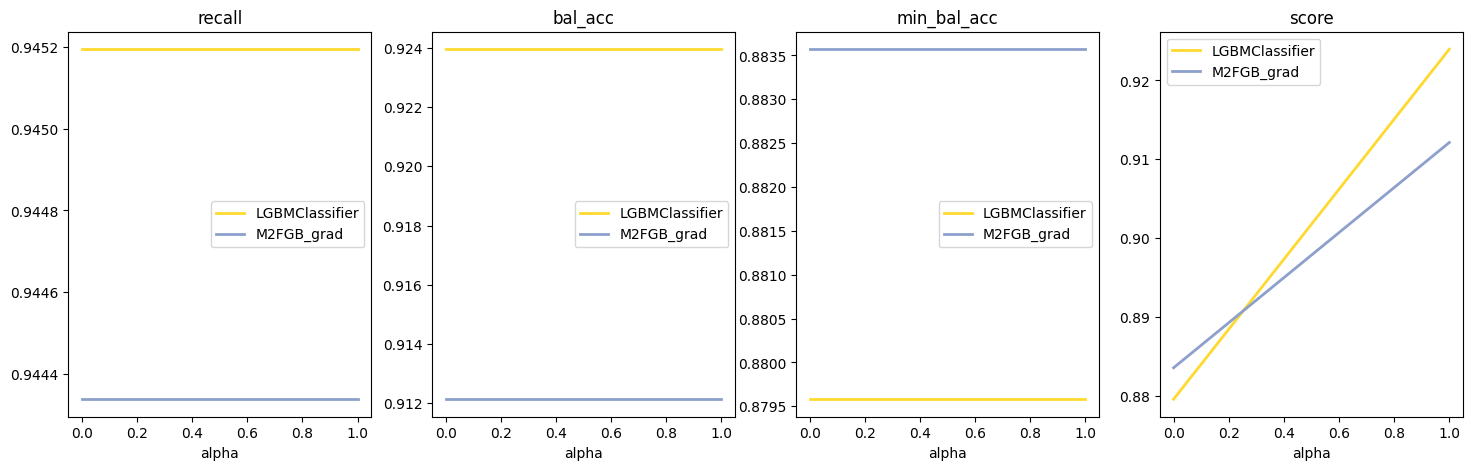

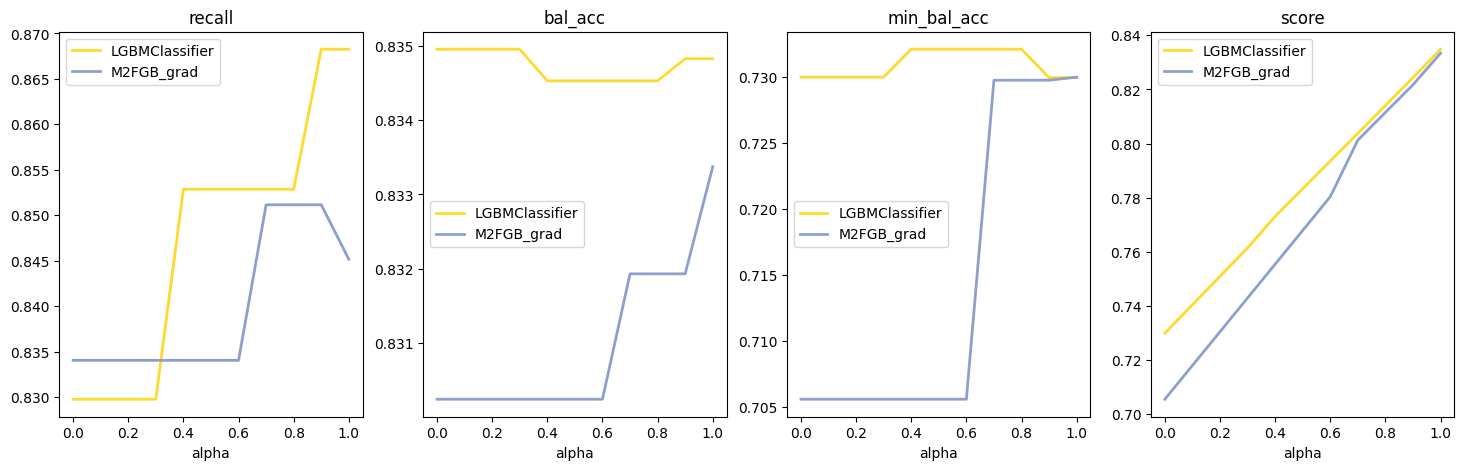

In [166]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

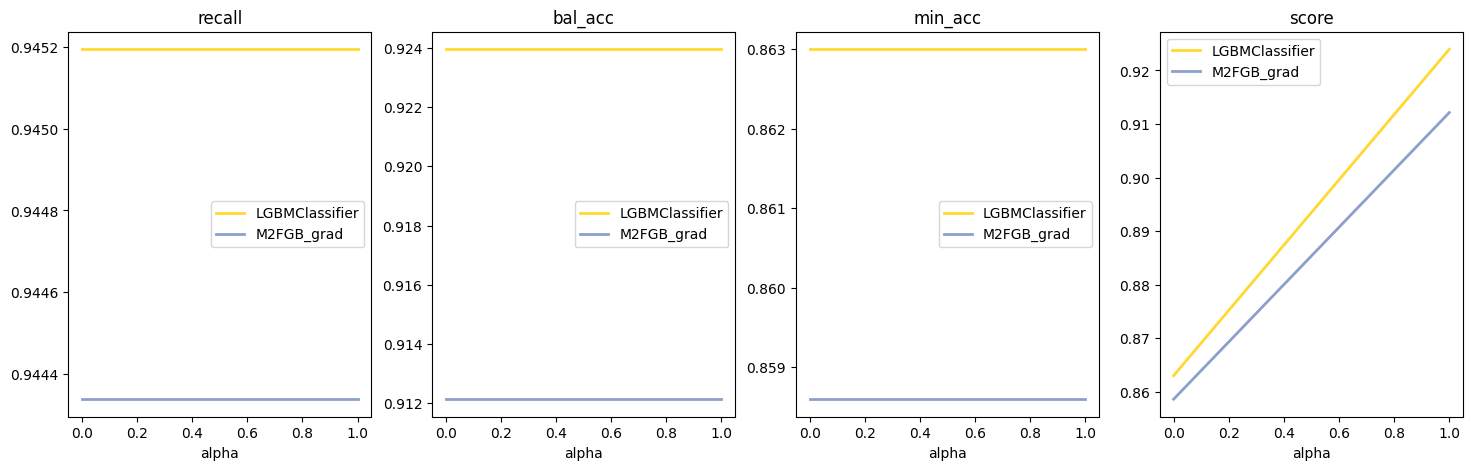

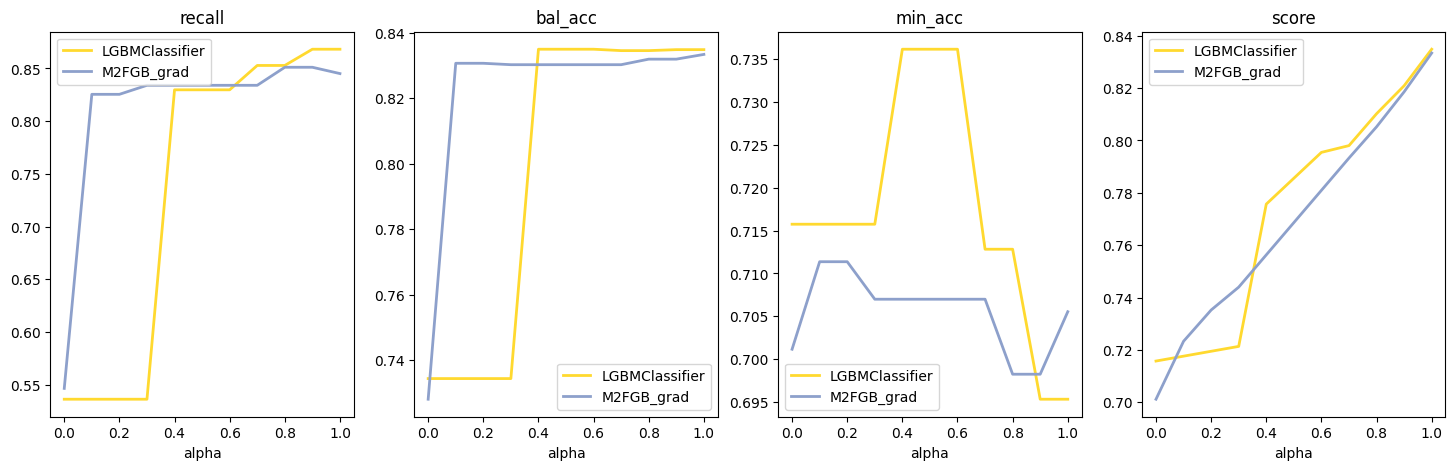

In [167]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

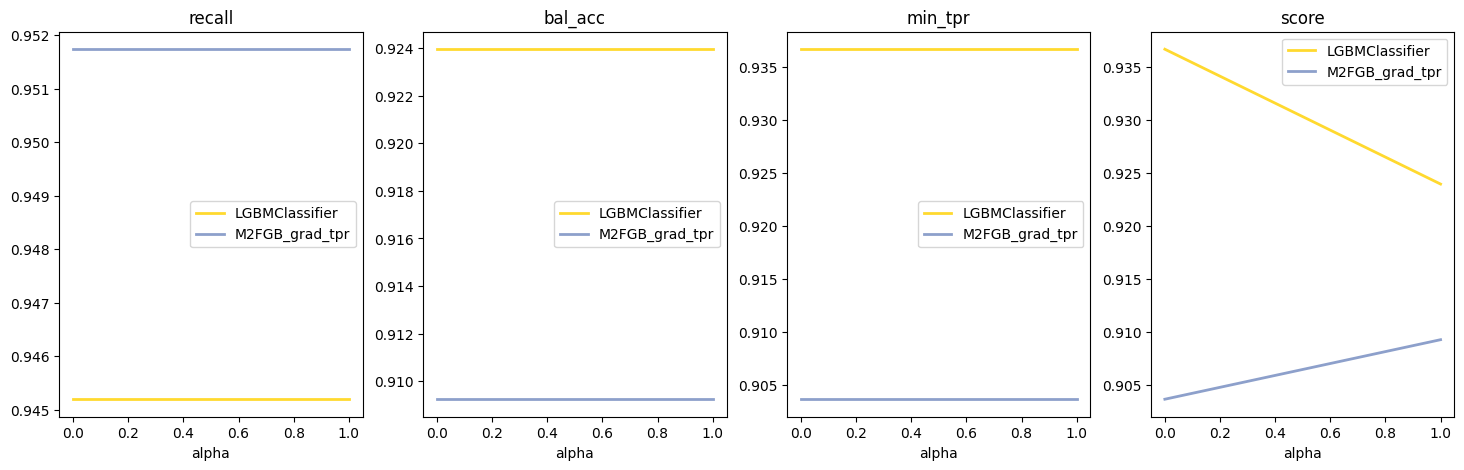

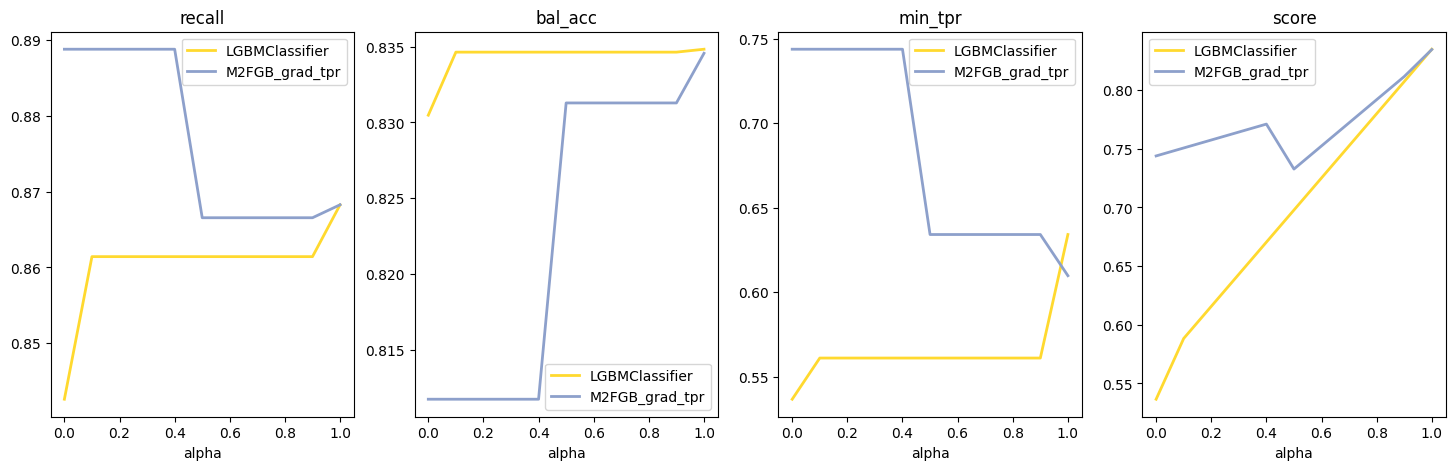

In [168]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

### fairgbm procedure

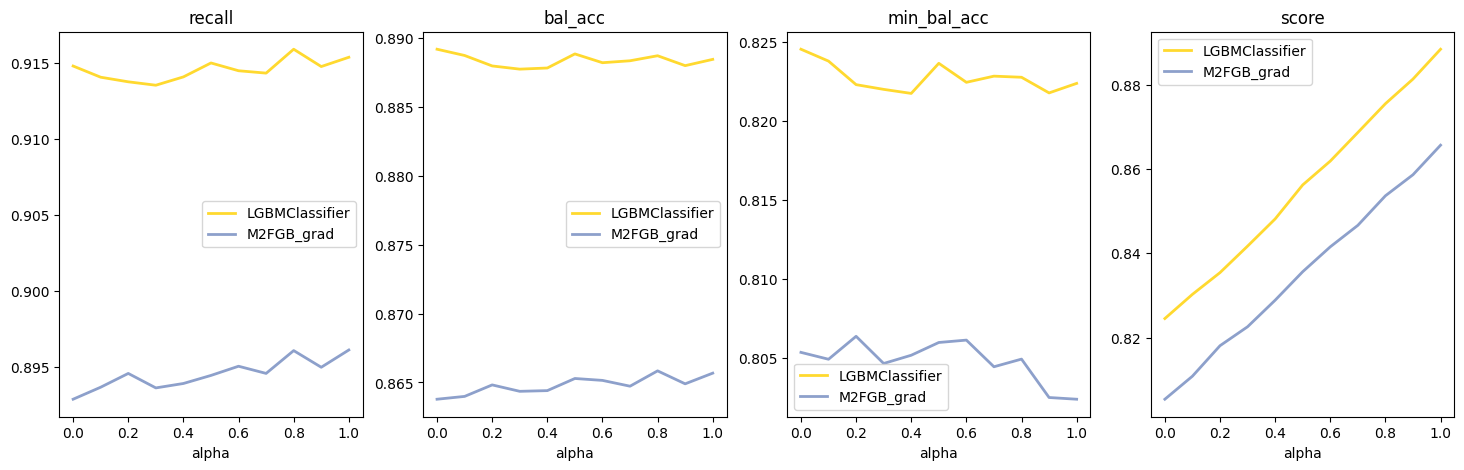

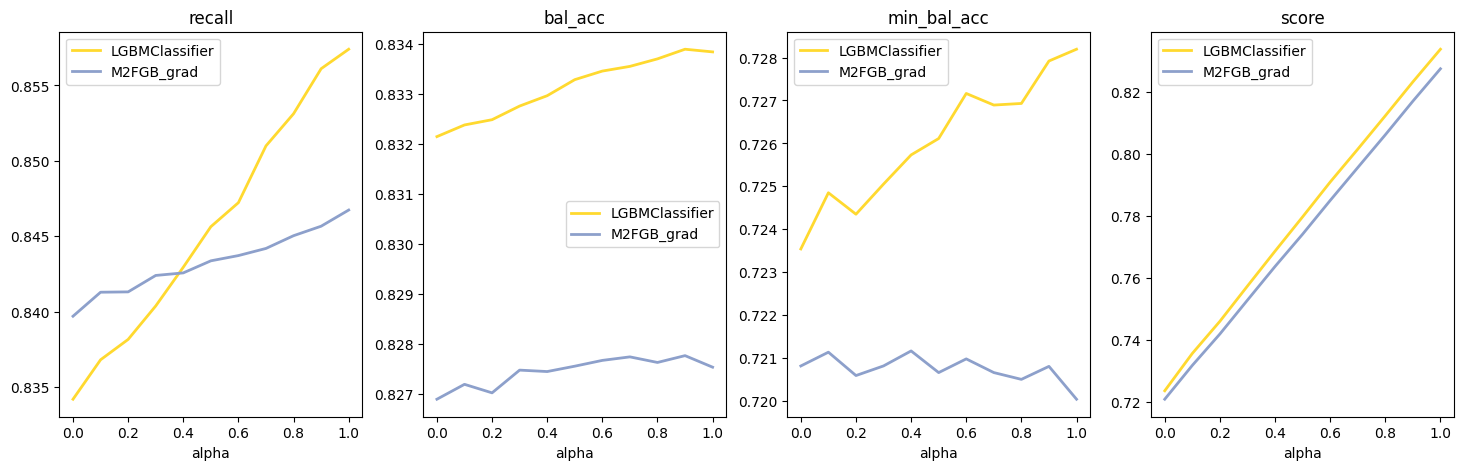

In [169]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

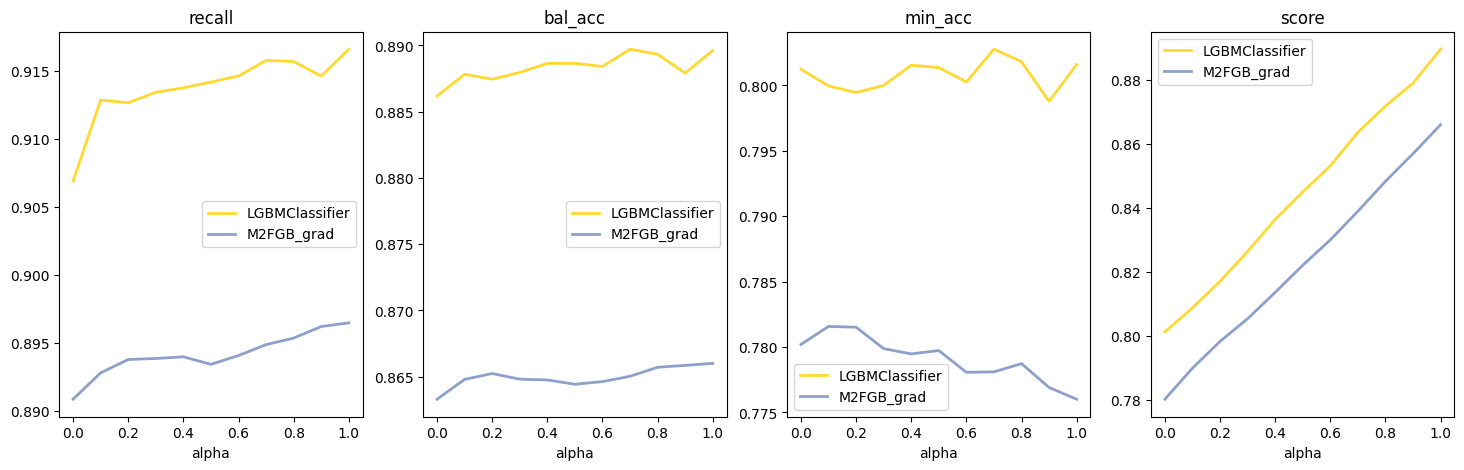

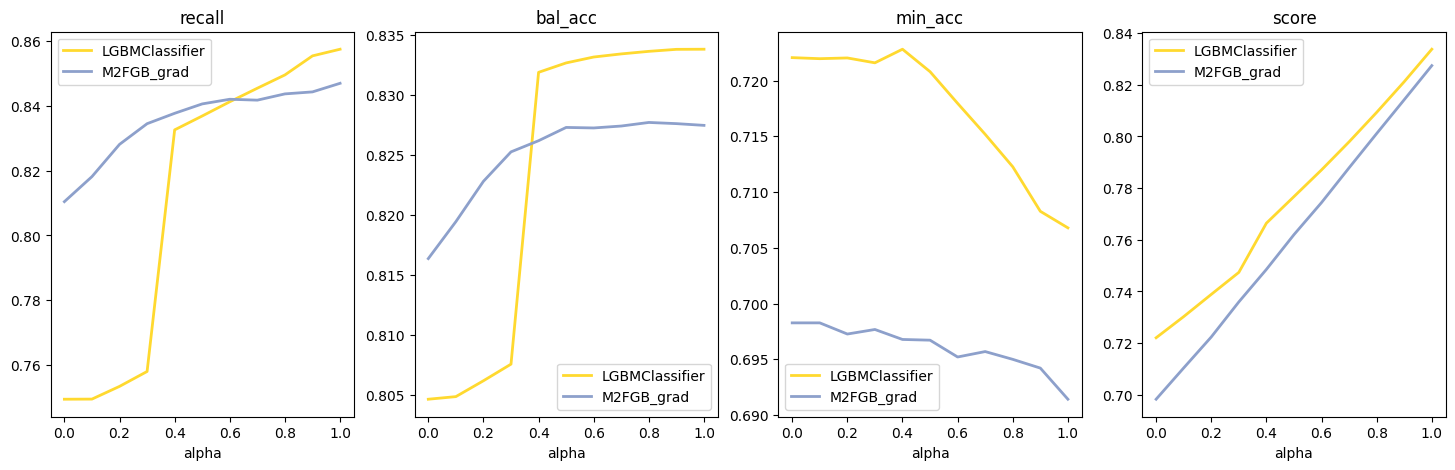

In [170]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

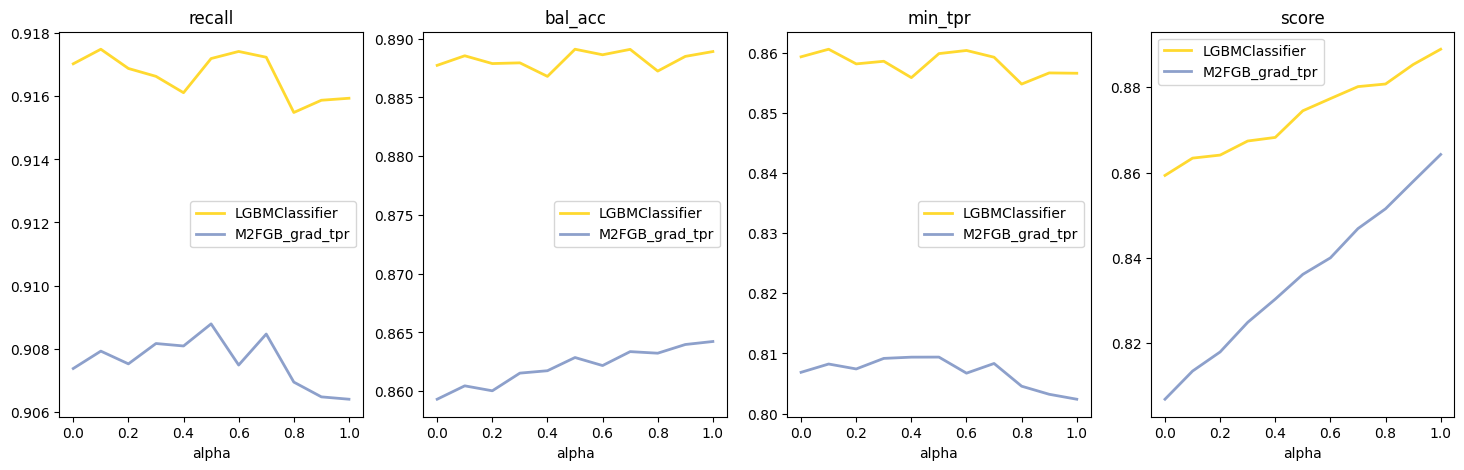

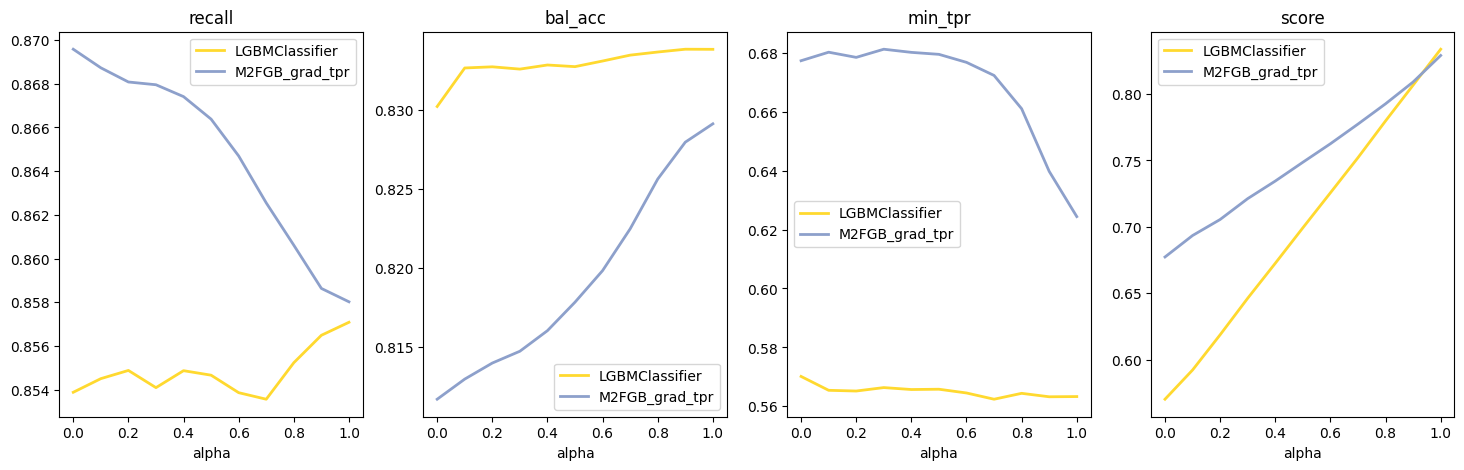

In [171]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_train"], results[model]["results_train"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

## with smaller feature space

In [100]:
def exp_v2(model, n_trials = 100):
    model_list = []
    param_space = experiments.get_param_spaces(model)
    # remove some parameters
    for param in ["min_child_weight", "reg_lambda", "max_depth"]:
        if param in param_space:
            del param_space[param]

    
    param_list = experiments.get_param_list(param_space, n_trials)
    model_class = experiments.get_model(model, random_state=seed)
    for params in tqdm(param_list):
        model_ = model_class(**params)
        model_.fit(X_train, Y_train, A_train)
        model_list.append(model_)
    
    results_val = eval_model_list(
        model_list,
        X_val,
        Y_val,
        A_val
    )

    results_test = eval_model_list(
        model_list,
        X_test,
        Y_test,
        A_test
    )

    return {
        "model_list" : model_list,
        "results_val" : results_val,
        "results_test" : results_test
    }

In [ ]:
results = {}
for model in ["LGBMClassifier", "M2FGB_grad", "M2FGB_grad_tpr"]:
    results[model] = exp_v2(model, 100)

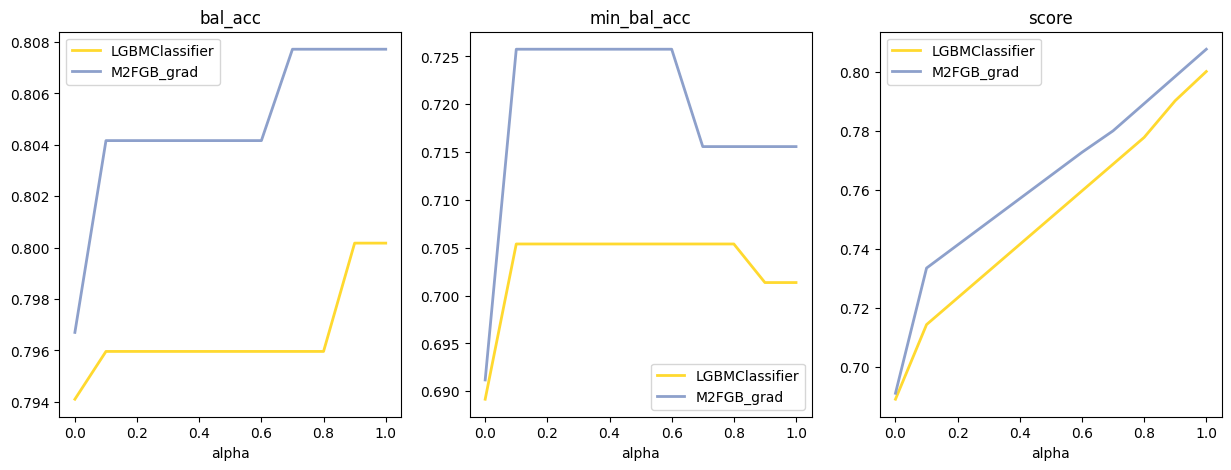

In [102]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

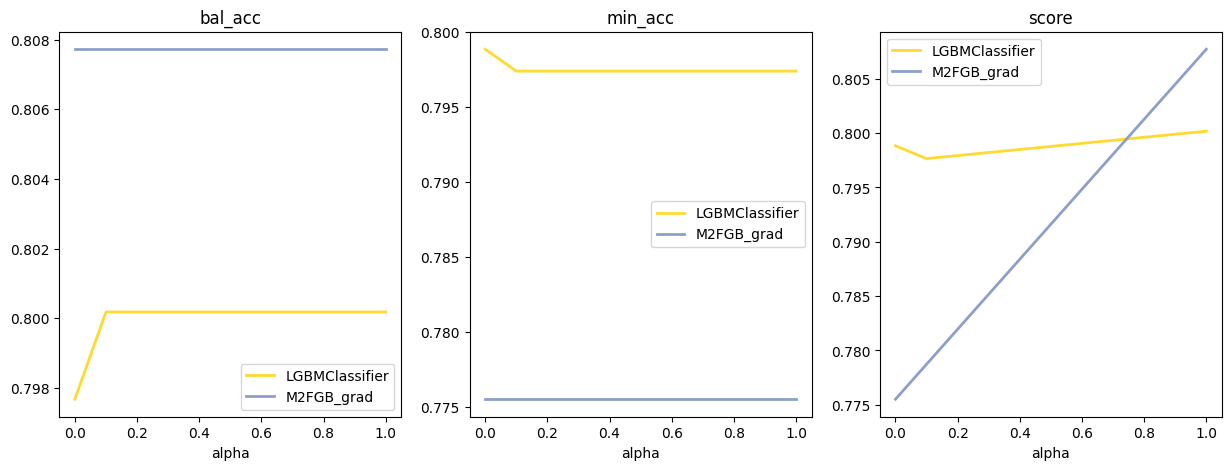

In [103]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

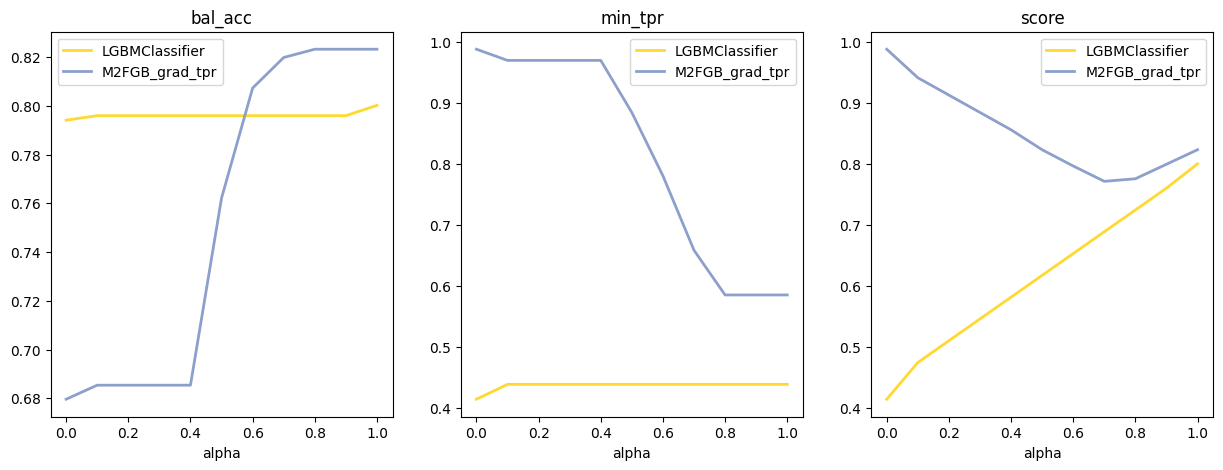

In [106]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

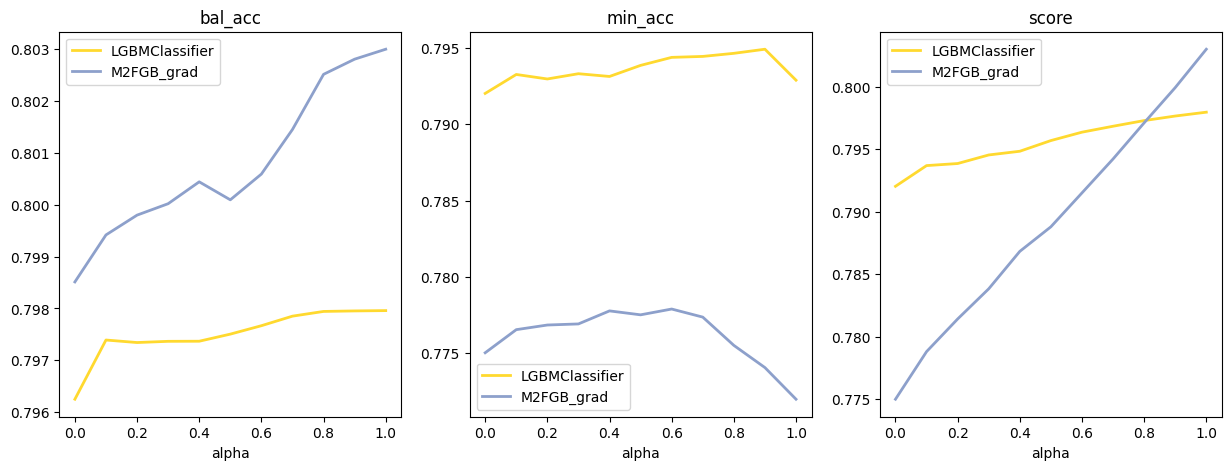

In [104]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_acc")

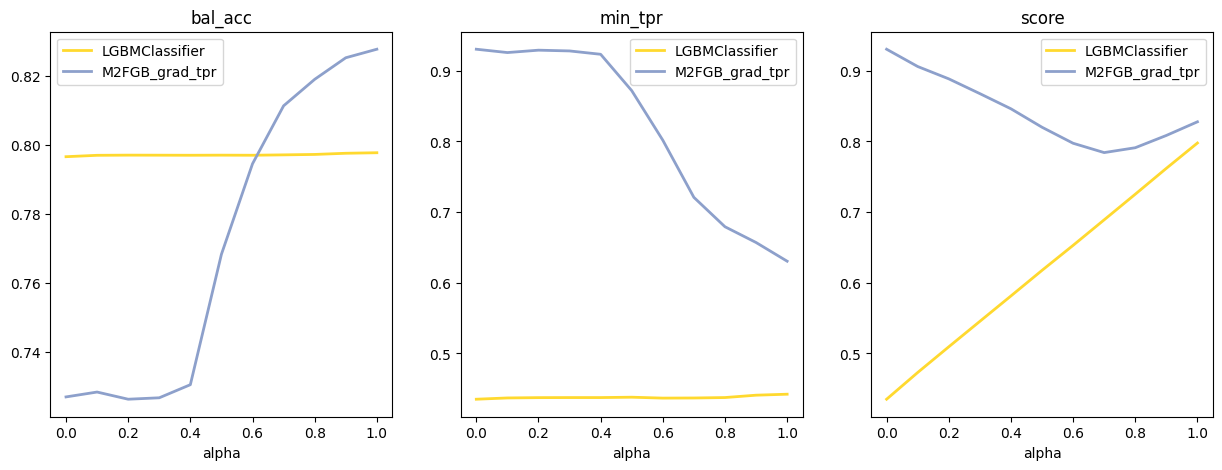

In [105]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad_tpr"]:
    df_results.append(select_model_alpha_fairgbm(model,results[model]["results_val"], results[model]["results_test"], "min_tpr"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_tpr")

## m2fgb but it is not fair

In [45]:
def exp_v3(model, n_trials = 100):
    model_list = []
    if model == "M2FGB_not_fair":
        param_space = experiments.get_param_spaces("M2FGB_grad")
        param_space["fair_weight"] = {"type": "float", "low": 0, "high": 0}
        del param_space["multiplier_learning_rate"]
    else:
        param_space = experiments.get_param_spaces(model)

    param_list = experiments.get_param_list(param_space, n_trials)
    if model == "M2FGB_not_fair":
        model_class = experiments.get_model("M2FGB_grad", random_state=seed)
    else:
        model_class = experiments.get_model(model, random_state=seed)
    
    threshold_list = []
    for params in tqdm(param_list):
        model_ = model_class(**params)
        model_.fit(X_train, Y_train, A_train)
        model_list.append(model_)
        # get the best threshold for each model
        y_score = model_.predict_proba(X_train)[:, 1]
        threshold_list.append(utils.get_best_threshold(Y_train, y_score))
    
    results_train = eval_model_list(
        model_list,
        X_train,
        Y_train,
        A_train,
        threshold_list
    )

    results_val = eval_model_list(
        model_list,
        X_val,
        Y_val,
        A_val,
        threshold_list
    )

    results_test = eval_model_list(
        model_list,
        X_test,
        Y_test,
        A_test,
        threshold_list
    )

    return {
        "model_list" : model_list,
        "results_train" : results_train,
        "results_val" : results_val,
        "results_test" : results_test
    }


In [199]:
results = {}
for model in ["LGBMClassifier", "M2FGB_grad"]:
    results[model] = exp_v3(model, 10)

  0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


In [181]:
alpha = 0.5
r = results["M2FGB_grad"]["results_val"]
score = r["bal_acc"] * alpha + r["min_bal_acc"] * (1 - alpha)
best_model = r.iloc[score.idxmax()].model.astype(int)
results["M2FGB_grad"]["model_list"][best_model].get_params()

{'dual_learning': 'gradient_norm',
 'fair_weight': 0.0,
 'fairness_constraint': 'equalized_loss',
 'learning_rate': 0.0943618630827465,
 'max_depth': 4,
 'min_child_weight': 0.16948559015014347,
 'multiplier_learning_rate': 0.01301069142473287,
 'n_estimators': 445,
 'random_state': 42,
 'reg_lambda': 0.1801179400998322}

In [189]:
alpha = 0.5
r = results["LGBMClassifier"]["results_val"]
score = r["bal_acc"] * alpha + r["min_bal_acc"] * (1 - alpha)
best_model = r.iloc[score.idxmax()].model.astype(int)
best_lgbm = results["LGBMClassifier"]["model_list"][best_model]

results["LGBMClassifier"]["model_list"][best_model].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.08570533879791281,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 0.020578640168915602,
 'min_split_gain': 0.0,
 'n_estimators': 121,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 1.881569015549866,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

In [197]:
m.model_.params

{'objective': 'none',
 'learning_rate': 0.08570533879791281,
 'max_depth': 9,
 'min_child_weight': 0.020578640168915602,
 'reg_lambda': 1.881569015549866,
 'verbose': -1,
 'random_seed': 42,
 'num_iterations': 121}

In [183]:
import models

In [211]:
param_space = experiments.get_param_spaces("LGBMClassifier")
param_list = experiments.get_param_list(param_space, 10)

for param in param_list:
    m = models.LGBMClassifier(**param)
    m.fit(X_train, Y_train, A_train)

    thresh = utils.get_best_threshold(Y_train, m.predict_proba(X_train)[:, 1])
    y_pred = m.predict_proba(X_val)[:, 1] > thresh

    lgbm_score = (
        balanced_accuracy_score(Y_val, y_pred),
        utils.min_balanced_accuracy(Y_val, y_pred, A_val)
    )



    m = models.M2FGB(fair_weight=0, **param)
    m.fit(X_train, Y_train, A_train)

    thresh = utils.get_best_threshold(Y_train, m.predict_proba(X_train)[:, 1])
    y_pred = m.predict_proba(X_val)[:, 1] > thresh

    m2fgb_score = (
        balanced_accuracy_score(Y_val, y_pred),
        utils.min_balanced_accuracy(Y_val, y_pred, A_val)
    )

    print(
        lgbm_score[0] - m2fgb_score[0],
        lgbm_score[1] - m2fgb_score[1]
    )



-0.0053207879912522404 0.006186585256352628
0.001614343731662915 2.244769686632342e-05
-0.0021185354207141627 0.0
0.002574395503209148 -0.008884798419682038
0.0031893187603329043 -0.0282796085121666
-0.0018712046641589097 0.00774445541887403
8.59984924169721e-05 -0.006976744186046546
-0.0011702829146181815 0.0011627906976743319
0.0005542251127396147 -0.0011627906976744429
-0.00033276197659470874 -0.0023255813953488857


In [208]:
m2fgb_score

(0.8139237685764685, 0.31912543773008883)

In [201]:
p = {
 'learning_rate': 0.08570533879791281,
 'max_depth': 9,
 
 'min_child_weight': 0.020578640168915602,

 'n_estimators': 121,
 
 'random_state': 42,
 
 'reg_lambda': 1.881569015549866,
}

m = models.M2FGB(fair_weight=0, **p)
m.fit(X_train, Y_train, A_train)

M2FGB(fair_weight=0, learning_rate=0.08570533879791281, max_depth=9,
      min_child_weight=0.020578640168915602, n_estimators=121, random_state=42,
      reg_lambda=1.881569015549866)

In [202]:
thresh = utils.get_best_threshold(Y_train, m.predict_proba(X_train)[:, 1])
Y_pred_val = m.predict_proba(X_val)[:, 1] > thresh
print(balanced_accuracy_score(Y_val, Y_pred_val))
print(1 - utils.min_accuracy(Y_val, Y_pred_val, A_val))

0.8304257220356275
0.7053701015965167


In [203]:
m = models.LGBMClassifier(**p)
m.fit(X_train, Y_train, A_train)

In [205]:
thresh = utils.get_best_threshold(Y_train, m.predict_proba(X_train)[:, 1])
Y_pred_val = m.predict_proba(X_val)[:, 1] > thresh
print(balanced_accuracy_score(Y_val, Y_pred_val))
print(1 - utils.min_accuracy(Y_val, Y_pred_val, A_val))

0.8345155289678774
0.6995645863570392


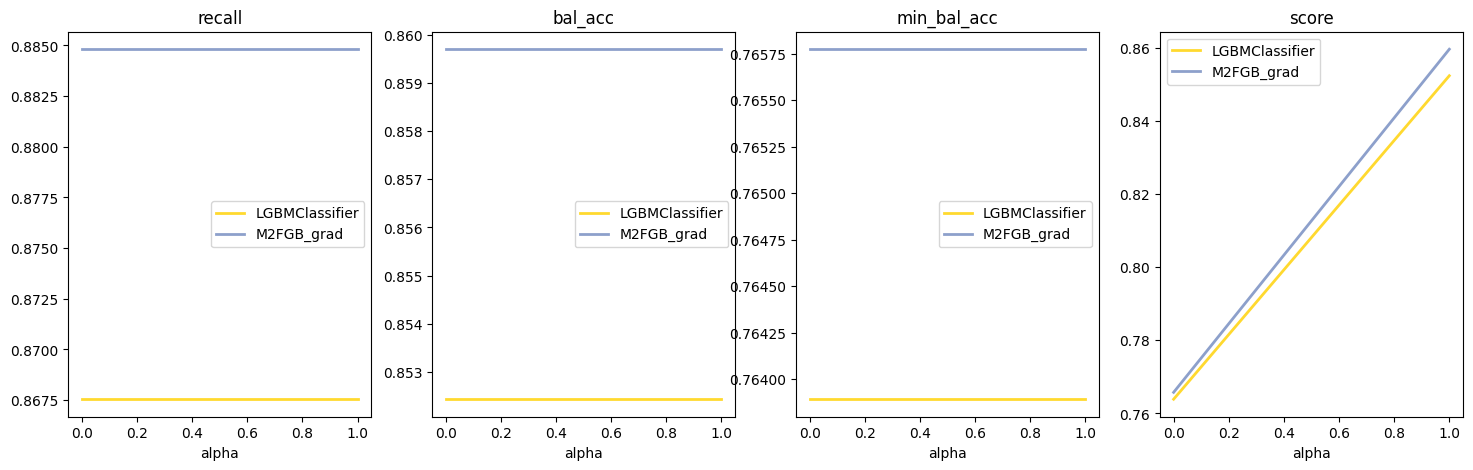

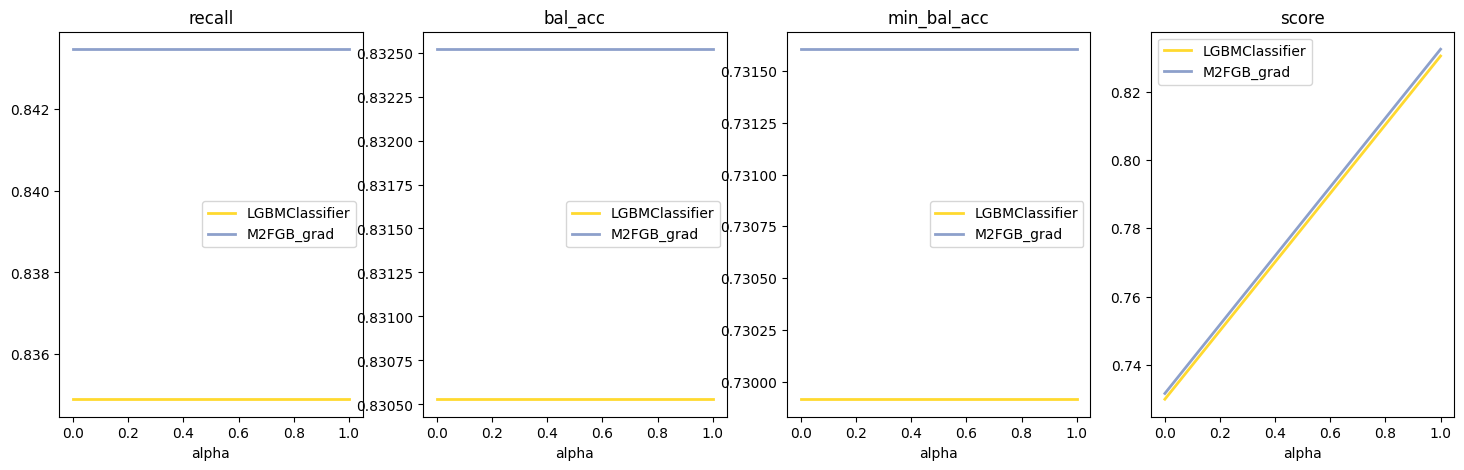

In [200]:
df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_train"], results[model]["results_train"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")


df_results = []
for model in ["LGBMClassifier", "M2FGB_grad"]:
    df_results.append(select_model_alpha(model,results[model]["results_val"], results[model]["results_test"], "min_bal_acc"))
df_results = pd.concat(df_results)
plot_perf_lines(df_results, "min_bal_acc")

## comparing booster and sklearn interfaces

In [238]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [243]:
m = LGBMClassifier()
m.fit(X_train, Y_train)
o1 = m.predict_proba(X_val)[:, 1]

In [245]:
dtrain = lgb.Dataset(X_train, label=Y_train)
m = lgb.train(
    {
        "objective": "binary",
    },
    dtrain,
)
o2 = m.predict(X_val)


m = lgb.train(
    {
        #"objective": "binary",
    },
    dtrain,
)
o3 = m.predict(X_val)

In [260]:
o2.min(), o2.mean(), o2.max()

(0.0002758198023886266, 0.24451812945255863, 0.9986751834300368)

In [259]:
np.abs(o1 - o2).max(), np.abs(o1 - o3).max()

(0.0, 0.5984151880040409)

In [268]:
def dual_obj_1(
    subgroup,
    fair_weight,
    group_losses,
    mu_opt_list,
    fairness_constraint="equalized_loss",
    dual_learning="optim",
    multiplier_learning_rate=0.1,
):
    """This helper function will define a custom objective function for XGBoost using the fair_weight parameter.

    Parameters
    ----------
    soubgroup : ndarray
        Array with the subgroup labels.
    fair_weight : float
        Weight of the fairness term in the loss function.
    group_losses : list
        List where the losses for each subgroup will be stored.
    mu_opt_list: list
        List where the optimal mu for each subgroup will be stored.
    fairness_constraint: str, optional
        Fairness constraint used in learning.
    dual_learning : str, optional
        Method used to learn the dual problem, by default "optim"
    multiplier_learning_rate: float, optional
        Learning rate used in the gradient learning of the dual, used only if dual_learning="gradient", by default 0.1
    """
    I = models.get_subgroup_indicator_test(subgroup)

    def custom_obj(y_true, y_pred):
        print("\t", y_pred.min(), y_pred.mean(), y_pred.max())
        y_pred = 1 / (1 + np.exp(-y_pred))
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)  # avoid log(0)
        print(y_pred.min(), y_pred.mean(), y_pred.max())
        loss_group = models.logloss_group(y_pred, y_true, subgroup, fairness_constraint)
        group_losses.append(loss_group)

        if dual_learning == "optim":
            # dual problem solved analytically
            idx_biggest_loss = np.where(loss_group == np.max(loss_group))[0]
            # if is more than one, randomly choose one
            idx_biggest_loss = np.random.choice(idx_biggest_loss)
            mu_opt = np.zeros(loss_group.shape[0])
            mu_opt[idx_biggest_loss] = fair_weight

        elif dual_learning == "gradient":
            if mu_opt_list[0] is None:
                mu_opt = np.zeros(loss_group.shape[0])
            else:
                mu_opt = mu_opt_list[-1].copy()
            mu_opt += multiplier_learning_rate * fair_weight * loss_group

        elif dual_learning == "gradient_norm":
            if mu_opt_list[0] is None:
                mu_opt = np.ones(loss_group.shape[0])
            else:
                mu_opt = mu_opt_list[-1].copy()

            mu_opt += multiplier_learning_rate * loss_group
            mu_opt = models.projection_to_simplex(mu_opt, z=fair_weight)

        elif dual_learning == "gradient_norm2":
            if mu_opt_list[0] is None:
                mu_opt = np.ones(loss_group.shape[0])
            else:
                mu_opt = mu_opt_list[-1].copy()

            mu_opt += multiplier_learning_rate * loss_group
            mu_opt = mu_opt / np.sum(mu_opt) * fair_weight

        if mu_opt_list[0] is None:
            mu_opt_list[0] = mu_opt
        else:
            mu_opt_list.append(mu_opt)

        grad_fair = models.logloss_group_grad(y_pred, y_true, fairness_constraint)
        # grad_fair = I * grad_fair.reshape(-1, 1) @ mu_opt
        grad_fair = I.multiply(grad_fair.reshape(-1, 1)) @ mu_opt

        hess_fair = models.logloss_group_hess(y_pred, y_true, fairness_constraint)
        hess_fair = I.multiply(hess_fair.reshape(-1, 1)) @ mu_opt
        # hess_fair = I * hess_fair.reshape(-1, 1) @ mu_opt

        grad = models.logloss_grad(y_pred, y_true)
        hess = models.logloss_hessian(y_pred, y_true)

        # It is not necessary to multiply fairness gradient by fair_weight because it is already included on mu
        # grad = (1 - fair_weight) * grad + fair_weight * grad_fair
        # hess = (1 - fair_weight) * hess + fair_weight * hess_fair

        grad = (1 - fair_weight) * grad + grad_fair
        hess = (1 - fair_weight) * hess + hess_fair

        return grad, hess

    return custom_obj

In [262]:
def custom_test(y_true, y_pred):
    print(y_pred)
    y_pred = 1 / (1 + np.exp(-y_pred))
    print(y_pred)
    grad = np.zeros_like(y_pred)
    hess = np.zeros_like(y_pred)
    return grad, hess

c = models.dual

m = LGBMClassifier(
    objective = custom_test,
    n_estimators = 1
)
m.fit(X_train, Y_train)


[0. 0. 0. ... 0. 0. 0.]
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


LGBMClassifier(n_estimators=1,
               objective=<function custom_test at 0x7fe9b322cc10>)

In [ ]:
group_losses = []
mu_opt_list = [None]

idx = np.argsort(A_train)
A_ = A_train.values[idx]
X_ = X_train.values[idx]
Y_ = Y_train.values[idx]

c = dual_obj_1(
    A_,
    0.9,
    group_losses,
    mu_opt_list,
    fairness_constraint="equalized_loss",
    dual_learning="gradient_norm",
    multiplier_learning_rate = 0.5,
)
m = LGBMClassifier(
    objective = c,
    n_estimators = 100
)
m.fit(X_, Y_)

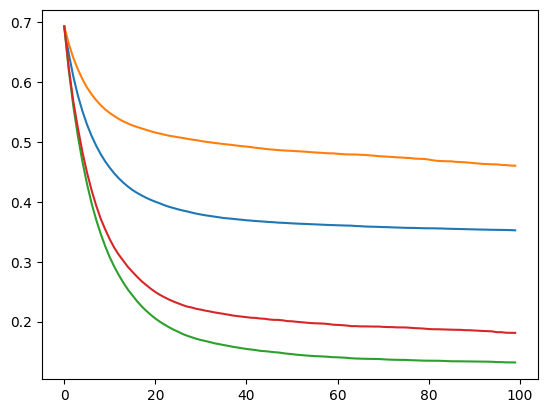

In [297]:
group_losses = np.array(group_losses)
for i in range(4):
    plt.plot(group_losses[:, i])

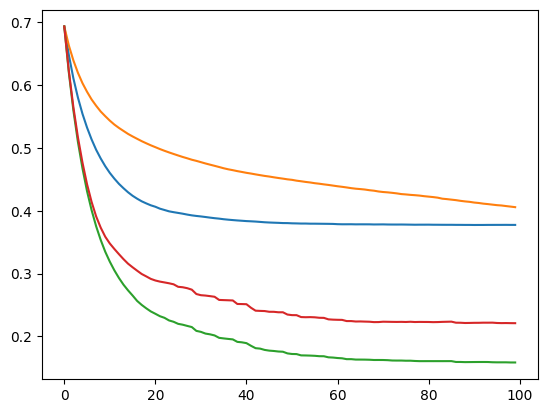

In [299]:
group_losses = np.array(group_losses)
for i in range(4):
    plt.plot(group_losses[:, i])

## alpha curve across folds

In [48]:
dataset = "taiwan"
seed = 42
n_folds = 5
df_results = []
for fold in range(n_folds):
    X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test =  data.get_fold(dataset, fold, n_folds, 8, seed)

    for model in ["LGBMClassifier", "M2FGB_grad"]:
        results_dict = exp_v1(model, n_trials = 100)
        results_ = select_model_alpha(model, results_dict["results_val"], results_dict["results_test"], "min_acc")
        results_["fold"] = fold
        df_results.append(results_)

df_results = pd.concat(df_results)

{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


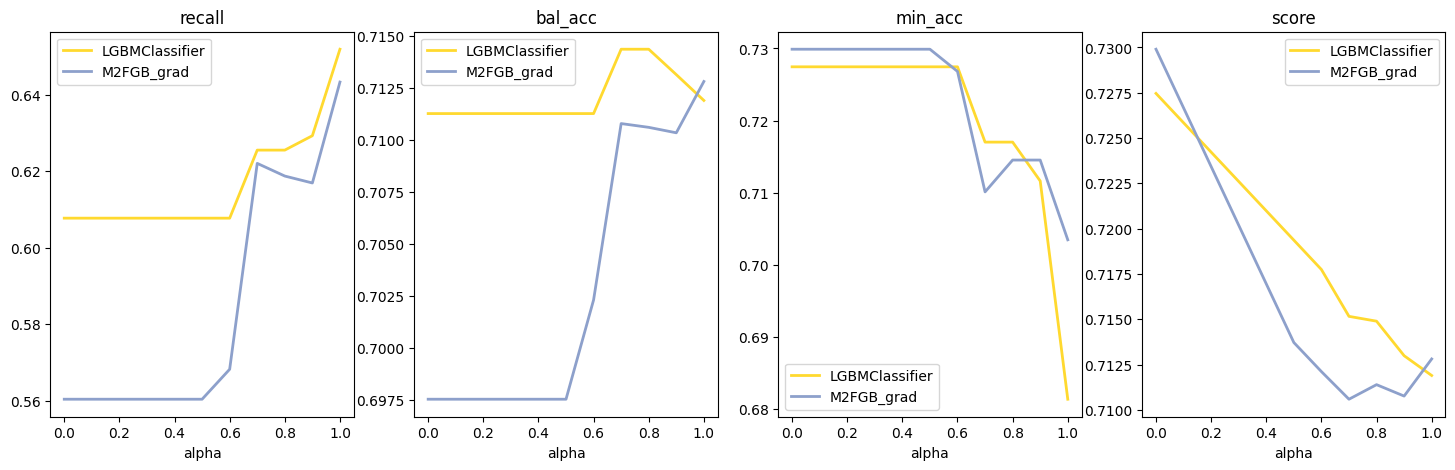

In [ ]:
plot_perf_lines(df_results.groupby(["model", "alpha"]).mean().reset_index(), "min_acc")

## alpha curve but with lgbm is a version of m2fgb

In [ ]:
dataset = "taiwan"
seed = 42
n_folds = 5
df_results = []
for fold in range(n_folds):
    X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test =  data.get_fold(dataset, fold, n_folds, 8, seed)

    for model in ["LGBMClassifier", "M2FGB_grad"]:
        results_dict = exp_v3(model, n_trials = 100)
        results_ = select_model_alpha(model, results_dict["results_val"], results_dict["results_test"], "min_acc")
        results_["fold"] = fold
        df_results.append(results_)

df_results = pd.concat(df_results)

{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


{'Female_1': 0, 'Female_2': 1, 'Male_4': 2, 'Male_2': 3, 'Male_1': 4, 'Female_4': 5, 'Female_3': 6, 'Male_3': 7}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


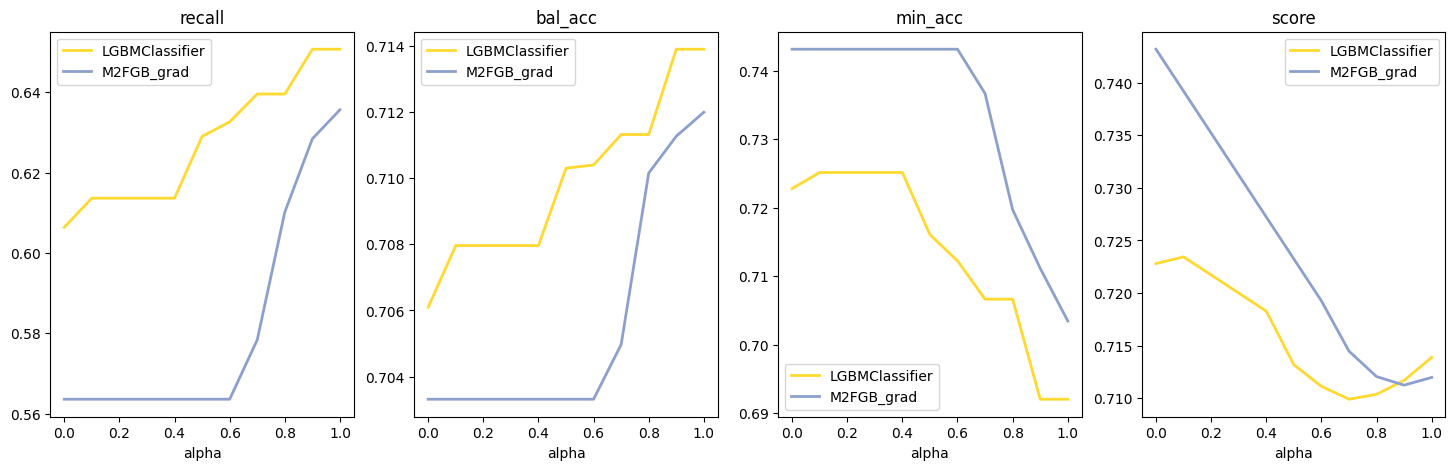

In [ ]:
plot_perf_lines(df_results.groupby(["model", "alpha"]).mean().reset_index(), "min_acc")